In [52]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

df = pd.read_csv (r'Test/submission.csv')
print (df)

       image_name                                               tags
0       file_1449                                      clear primary
1      test_19110                              partly_cloudy primary
2      file_14872  agriculture clear cultivation habitation prima...
3      test_22084                                      clear primary
4      file_14649                                clear primary water
...           ...                                                ...
61186   file_8747              agriculture clear cultivation primary
61187  test_21325                           clear primary road water
61188  test_22673                                      clear primary
61189   file_5377                                      clear primary
61190  file_19122       agriculture partly_cloudy primary road water

[61191 rows x 2 columns]


In [53]:
tagdictionary={}
columns=(df.tags.tolist())

In [54]:
for i in columns:
    words=i.split()
    for j in words:
        if j in tagdictionary.keys():
            tagdictionary[j]=tagdictionary[j]+1
        else:
            tagdictionary[j]=1
dactictionarysorted=sorted(tagdictionary.items(),key=lambda x:x[1])
print(dactictionarysorted)

[('conventional_mine', 137), ('blow_down', 150), ('blooming', 212), ('slash_burn', 265), ('artisinal_mine', 537), ('selective_logging', 582), ('bare_ground', 1553), ('cloudy', 4179), ('haze', 5317), ('habitation', 6681), ('cultivation', 10331), ('partly_cloudy', 12518), ('water', 12729), ('road', 14626), ('agriculture', 23570), ('clear', 45685), ('primary', 58411)]


In [55]:
taglist=list(tagdictionary.keys())
print(taglist)

['clear', 'primary', 'partly_cloudy', 'agriculture', 'cultivation', 'habitation', 'road', 'water', 'haze', 'cloudy', 'selective_logging', 'bare_ground', 'artisinal_mine', 'blow_down', 'slash_burn', 'blooming', 'conventional_mine']


In [56]:
def encodingbinaryArray(taglist,tags):
    encoding=np.zeros(len(taglist),dtype='uint8')
    #print(type(encoding))
    for tag in tags:
        index=taglist.index(tag)
        encoding[index]=1
    return encoding
print(encodingbinaryArray(taglist,["clear","cloudy"]))



[1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [57]:
def filePrepare(df):
    imgnames=df.image_name.tolist()
    tags=[]
    for s in df.tags.tolist():
        tags.append(s.split(" "))
    return [imgnames,tags]
result=filePrepare(df)
print(result[0][0:20])
print(result[1][0:20])

['file_1449', 'test_19110', 'file_14872', 'test_22084', 'file_14649', 'test_25653', 'file_9993', 'file_12052', 'file_4863', 'test_29333', 'file_3138', 'test_6636', 'test_10993', 'test_3770', 'test_38812', 'test_5820', 'test_6336', 'file_3652', 'file_16145', 'test_10158']
[['clear', 'primary'], ['partly_cloudy', 'primary'], ['agriculture', 'clear', 'cultivation', 'habitation', 'primary', 'road'], ['clear', 'primary'], ['clear', 'primary', 'water'], ['clear', 'primary'], ['clear', 'primary', 'water'], ['agriculture', 'haze', 'primary', 'road', 'water'], ['agriculture', 'clear', 'cultivation', 'haze', 'primary'], ['clear', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary'], ['cloudy', 'partly_cloudy', 'primary'], ['partly_cloudy', 'primary'], ['clear', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary'], ['clear', 'primary'], ['clear', 'primary'], ['partly_cloudy', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary'], ['cloudy']]


In [58]:
def encodingBinaryPrepare(tags):
    encodedlist=[]
    for i in tags:
        encodedlist.append(encodingbinaryArray(taglist,i))
                        
    return encodedlist


file_names=result[0]
file_tags=encodingBinaryPrepare(result[1]) 
#print(file_names)
#print(file_tags)
    

In [59]:
len(file_names)

61191

In [9]:
def prepare_X_y(path,file_names,file_tags):
    photos,codes=list(),list()
    i=0
    for file_name in file_names:
        #dirname = os.path.dirname(__file__)
        realfilename = 'Test/test-jpg/'+file_name+'.jpg'
        photo=load_img(realfilename,target_size=(96,96))
        photo=img_to_array(photo,dtype="uint8")
        photos.append(photo)
        codes.append(file_tags[i])
        i=i+1
    
    X=np.asarray(photos,dtype='uint8')
    y=np.asarray(codes,dtype='uint8')
    return X,y
X,y=prepare_X_y("path",file_names,file_tags)
print(X.shape)
print(y.shape)

(61191, 96, 96, 3)
(61191, 17)


In [10]:
np.savez_compressed('Loaded_Images_Tags_For_Testing_Purpose.npz',X,y)

In [60]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD

In [61]:
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [62]:
model=load_model("Epochs/1_Model",custom_objects={'fbeta':fbeta},compile=False)
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

In [14]:
model.evaluate(x=X, y=y)

1913/1913 [==============================] - 520s 269ms/step - loss: 88.2830 - fbeta: 0.2719


[87.53743743896484, 0.27343037724494934]

test_38388
['partly_cloudy', 'primary', 'water']
[0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


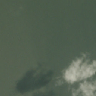

[0.0, 1.1499861e-33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['cloudy']


In [44]:
def predict(i):
    print(result[0][i])
    print(result[1][i])
    print(y[i])
    photo=load_img("Test/test-jpg/"+result[0][i]+'.jpg',target_size=(96,96))
    display(photo)
    l=list(model.predict(X[i:i+1])[0])
    tags=[]
    print(l)
    for i in range(len(l)):
        if(l[i]>=0.5):
            tags.append(taglist[i])
    print(tags)
    
predict(12778)

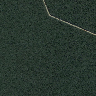

[0.0, 1.0, 1.3144541e-09, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['primary', 'agriculture', 'cultivation', 'habitation', 'road']


In [70]:
def predict_custom(i):
    photos=list()
    photo=load_img("Test/custom-jpg/"+str(i)+'.JPG',target_size=(96,96))
    display(photo)
    photo=img_to_array(photo,dtype="uint8")
    photos.append(photo)
    plist=np.asarray(photos,dtype='uint8')
    l=list(model.predict(plist[0:1])[0])
    tags=[]
    print(l)
    for i in range(len(l)):
        if(l[i]>=0.5):
            tags.append(taglist[i])
    print(tags)
    
predict_custom(6)